# This notebook is mainly for testing functions

In [1]:
import numpy as np
from utils import *
from data import *
from models import *
import matplotlib.pyplot as plt

# Testing AMR and MR estimation

In [65]:

# generic parameters
# Parameters
n = 800
n_mc = 1000000
num_trial = 1000
gamma=10
heteroscedasticity=False
strength_instr = 0.8
p_instr=12
p = 5+p_instr
data_mc = generate_synthetic_data(n_mc, p = p, p_instr=p_instr , gamma=gamma, strength_instrument= strength_instr, heteroscedasticity=heteroscedasticity, mu1_type='non_linear')
ate = np.mean(data_mc['mu1'] - data_mc['mu0'])
print("ate: ", ate)
df = generate_synthetic_data(n=n,p=p, p_instr = p_instr, strength_instrument=strength_instr, gamma=gamma,mu1_type='non_linear')
random_seed = 1024


ate:  4.994848299375249


In [3]:
n = 800  # Training sample size
nI = 2  # Fixed number of instrumental variables
nX = 2
nO = 2
nS = 3
p = nI+nX+nO+nS
ate = 2
beta_cov = 0
strength_instr = 1
strength_conf = 1
strength_outcome = 1
df = generate_data_causl(n=n, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome)
print("ate: ", ate)
random_seed = 1024

ate:  2


(array([110., 107.,  64.,  56.,  56.,  64.,  78.,  76.,  86., 103.]),
 array([0.00252458, 0.10206701, 0.20160944, 0.30115188, 0.40069431,
        0.50023674, 0.59977918, 0.69932161, 0.79886405, 0.89840648,
        0.99794891]),
 <BarContainer object of 10 artists>)

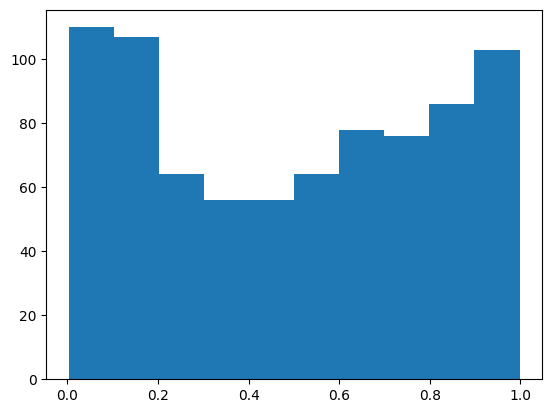

In [4]:
plt.hist(df['propen'])

In [66]:
df1, df2 = [df_s.reset_index(drop=True) for df_s in np.array_split(df.sample(frac=1, random_state=2025), 2)]

nuis_params = single_split_nuisance_parameter_estimator(
    df1, df2, p, ps_model_type="original", or_model_type="torch_nn", w_model_type="kernel_ridge_regression",
    hyperparam_search=True, random_seed=2
)
ate_mr = ate_mr_estimator(nuis_params['hat_w1'], nuis_params['hat_w0'], df2)
ate_mr_tilde = ate_amr_estimator(nuis_params['hat_tilde_w'], nuis_params['hat_propen'], nuis_params['hat_mu1'], nuis_params['hat_mu0'], df2)
ate_dr = ate_aipw_estimator(nuis_params['hat_mu1'], nuis_params['hat_mu0'], nuis_params['hat_propen'], df2)
ate_ipw = ate_ipw_estimator(nuis_params['hat_propen'], df2)
print("ate_mr: ", ate_mr)
print("ate_mr_tilde: ", ate_mr_tilde)
print("ate_dr: ", ate_dr)
print("ate_ipw: ", ate_ipw)

Best Params: {'gamma': 0.001, 'alpha': 0.2}
Best Params: {'gamma': 0.001, 'alpha': 0.5}
Best Params: {'gamma': 0.001, 'alpha': 0.5}
ate_mr:  13.316148776839022
ate_mr_tilde:  2.826722134016787
ate_dr:  10.580315492957384
ate_ipw:  3.875363849039062


In [72]:
nuis_params = kfold_cross_fit_nuisance_parameter_estimator(
    df_full=df, p=p, ps_model_type="lr", or_model_type="torch_nn", w_model_type="kernel_ridge_regression",
    hyperparam_search=True, random_seed=42, n_folds=4
)
ate_mr = ate_mr_estimator(nuis_params['hat_w1'], nuis_params['hat_w0'], df)
ate_mr_tilde = ate_amr_estimator(nuis_params['hat_tilde_w'], nuis_params['hat_propen'], nuis_params['hat_mu1'], nuis_params['hat_mu0'], df)
ate_dr = ate_aipw_estimator(nuis_params['hat_mu1'], nuis_params['hat_mu0'], nuis_params['hat_propen'], df)
ate_ipw = ate_ipw_estimator(nuis_params['hat_propen'], df)
print("ate_mr: ", ate_mr)
print("ate_mr_tilde: ", ate_mr_tilde)
print("ate_dr: ", ate_dr)
print("ate_ipw: ", ate_ipw)

Best Params: {'gamma': 0.001, 'alpha': 0.5}
Best Params: {'gamma': 0.003593813663804626, 'alpha': 0.5}
Best Params: {'gamma': 0.001, 'alpha': 0.5}
Best Params: {'gamma': 0.001, 'alpha': 0.5}
Best Params: {'gamma': 0.001, 'alpha': 0.2}
Best Params: {'gamma': 0.001, 'alpha': 0.5}
Best Params: {'gamma': 0.001, 'alpha': 0.5}
Best Params: {'gamma': 0.003593813663804626, 'alpha': 0.5}
Best Params: {'gamma': 0.001, 'alpha': 0.5}
Best Params: {'gamma': 0.001, 'alpha': 0.2}
Best Params: {'gamma': 0.001, 'alpha': 0.5}
Best Params: {'gamma': 0.001, 'alpha': 0.5}
ate_mr:  11.433917503448413
ate_mr_tilde:  5.303374659727471
ate_dr:  9.30965165083018
ate_ipw:  12.747581191401318


In [5]:
pd.DataFrame(nuis_params)

,hat_propen,hat_mu0,hat_mu1,hat_w1,hat_w0,hat_tilde_w
0,0.006460,7.073136,25.902933,0.934112,1.213007,-0.304600
1,0.120450,6.220602,31.662632,0.648525,1.034325,-0.256901
2,0.102574,31.937017,43.761711,1.245843,0.232503,-0.145473
3,0.967762,27.907238,14.207905,1.274719,0.439818,-0.208476
4,0.318536,49.218151,33.863640,0.635026,0.886219,-0.291620
...,...,...,...,...,...,...
795,0.486088,21.201612,26.043442,0.953319,1.280097,-0.024904
796,0.713397,41.011234,69.677658,0.875915,0.865737,0.635343
797,0.946442,17.466320,15.138330,0.836812,1.125598,-0.369172
798,0.089317,9.752862,12.435275,1.020336,0.724844,-0.298306


# Testing Estimation on News

In [2]:
df = News(exp_num=1,train_size=1).get_df()

In [3]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X3473,X3474,X3475,X3476,X3477,A,y,propen,mu0,mu1
0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.87220,NaN,2.9834,3.051400
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.18040,NaN,1.8885,2.192700
2,0.0,0.0,21.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.74032,NaN,2.1768,2.266700
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.94750,NaN,1.8775,1.987100
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.49250,NaN,2.5771,2.691900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,19.40300,NaN,3.3198,19.358999
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.48680,NaN,2.8702,2.896400
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.34930,NaN,4.0102,4.881500
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4.75910,NaN,3.7504,4.266700


In [4]:
df1, df2 = [df_s.reset_index(drop=True) for df_s in np.array_split(df.sample(frac=1, random_state=2025), 2)]

nuis_params = single_split_nuisance_parameter_estimator(
    df1, df2, 3477, ps_model_type="torch_nn", or_model_type="torch_nn", w_model_type="kernel_ridge_regression",
    hyperparam_search=True, random_seed=2
)
ate_mr = ate_mr_estimator(nuis_params['hat_w1'], nuis_params['hat_w0'], df2)
ate_mr_tilde = ate_amr_estimator(nuis_params['hat_tilde_w'], nuis_params['hat_propen'], nuis_params['hat_mu1'], nuis_params['hat_mu0'], df2)
ate_dr = ate_aipw_estimator(nuis_params['hat_mu1'], nuis_params['hat_mu0'], nuis_params['hat_propen'], df2)
ate_ipw = ate_ipw_estimator(nuis_params['hat_propen'], df2)
print("ate_mr: ", ate_mr)
print("ate_mr_tilde: ", ate_mr_tilde)
print("ate_dr: ", ate_dr)
print("ate_ipw: ", ate_ipw)

ate_mr:  1.7479024
ate_mr_tilde:  2.174047
ate_dr:  -275.0133
ate_ipw:  477.2449


In [5]:
nuis_params = kfold_cross_fit_nuisance_parameter_estimator(
    df_full=df, p=3477, ps_model_type="torch_nn", or_model_type="torch_nn", w_model_type="kernel_ridge_regression",
    hyperparam_search=True, random_seed=2024, n_folds=2
)
ate_mr = ate_mr_estimator(nuis_params['hat_w1'], nuis_params['hat_w0'], df)
ate_mr_tilde = ate_amr_estimator(nuis_params['hat_tilde_w'], nuis_params['hat_propen'], nuis_params['hat_mu1'], nuis_params['hat_mu0'], df)
ate_dr = ate_aipw_estimator(nuis_params['hat_mu1'], nuis_params['hat_mu0'], nuis_params['hat_propen'], df)
ate_ipw = ate_ipw_estimator(nuis_params['hat_propen'], df)
print("ate_mr: ", ate_mr)
print("ate_mr_tilde: ", ate_mr_tilde)
print("ate_dr: ", ate_dr)
print("ate_ipw: ", ate_ipw)

ate_mr:  1.7006500689782442
ate_mr_tilde:  2.050548591790864
ate_dr:  -225.04172691886743
ate_ipw:  1263.2355387593266


In [6]:
np.mean(df['mu1']-df['mu0'])

2.3943994

## Testing synthetic data

In [6]:
p_instr = 4
#p_confound = 0
p_confound = 1
p_spurious = 0
p_outcome = 1
p = p_instr + p_confound + p_spurious + p_outcome
gamma_homo = 5
gamma_hetero = 0
beta_instr = 1
beta_confound = 0.2
beta_outcome = 1
heteroscedasticity = False
heterogeneous_treatment = True

n= 3000

df= generate_synthetic_data_v2(n=3000, p_instr=p_instr, p_confound=p_confound, p_spurious=p_spurious, p_outcome=p_outcome, gamma_homo=gamma_homo, gamma_hetero=gamma_hetero, 
                            beta_instr=beta_instr, beta_confound=beta_confound, beta_outcome=beta_outcome, propen_model='lr', 
                            heteroscedasticity=heteroscedasticity, outcome_type='nonlinear',  misspecified_propen=False, 
                            heterogeneous_treatment=heterogeneous_treatment)

<Axes: >

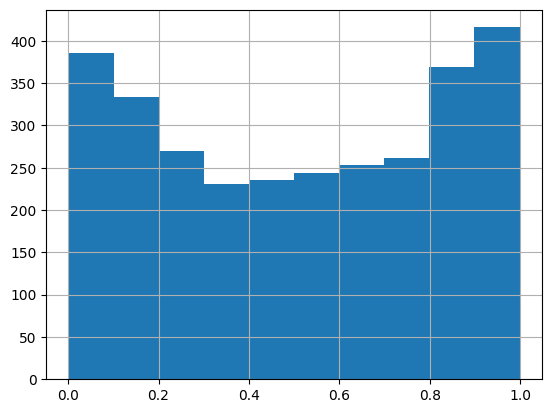

In [7]:
df['propen'].hist()

In [281]:
random_seed = 42
df1, df2 = [df_s.reset_index(drop=True) for df_s in np.array_split(df.sample(frac=1, random_state=random_seed), 2)]
df1.shape[0]
df2.shape[0]
nuis_params = nuisance_parameter_estimator(df=df, df1=df1, df2=df2, p=p, ps_model = 'original', or_model='original', w_model='kernel_ridge_regression', hyperparam_search=True, random_seed=random_seed)


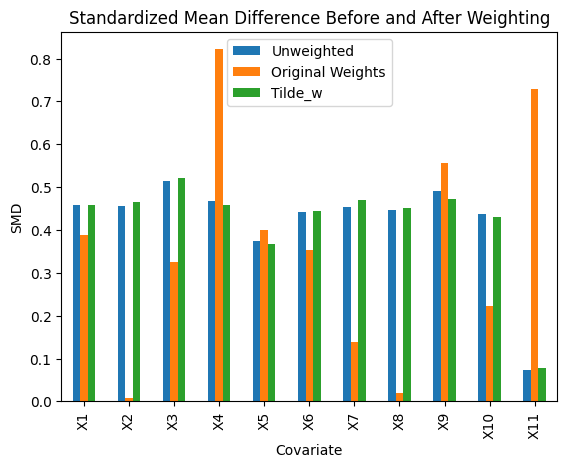

In [268]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Assuming df contains your synthetic data with covariates and treatment/outcome columns
X = df2[[f'X{i+1}' for i in range(p)]]  # Your covariates, divided into types
A = df2['A']
pi = nuis_params['hat_propen']  # Assumed available

# Calculate original weights (with correct handling for control group)
original_weights = np.where(A == 1, (A - pi) / (pi * (1 - pi)), -((A - pi) / (pi * (1 - pi))))

# Assuming tilde_w is available
tilde_w = nuis_params['hat_tilde_w']
# tilde_w = np.where(A == 1, tilde_w, -tilde_w)

# Function to calculate standardized mean difference (SMD)
def compute_smd(treated, control, weights_treated=None, weights_control=None):
    treated_mean = np.average(treated, weights=weights_treated) if weights_treated is not None else np.mean(treated)
    control_mean = np.average(control, weights=weights_control) if weights_control is not None else np.mean(control)

    pooled_var = (np.var(treated, ddof=1) + np.var(control, ddof=1)) / 2
    return abs(treated_mean - control_mean) / np.sqrt(pooled_var)
    # return abs(treated_mean - control_mean)
    
# Split treatment and control groups
treated = df2[df2['A'] == 1]
control = df2[df2['A'] == 0]

# Calculate SMD for each covariate
smd_results = {}
for covariate in X.columns:
    smd_results[covariate] = {
        'unweighted': compute_smd(treated[covariate], control[covariate]),
        'original_weights': compute_smd(treated[covariate], control[covariate], 
                                        original_weights[treated.index], original_weights[control.index]),
        'tilde_w': compute_smd(treated[covariate], control[covariate], tilde_w[treated.index], tilde_w[control.index])
    }

# Convert to a DataFrame for plotting
smd_df = pd.DataFrame(smd_results).T

# Plot the SMD for comparison
import matplotlib.pyplot as plt

smd_df.plot(kind='bar')
plt.title('Standardized Mean Difference Before and After Weighting')
plt.xlabel('Covariate')
plt.ylabel('SMD')
plt.legend(['Unweighted', 'Original Weights', 'Tilde_w'])
plt.show()


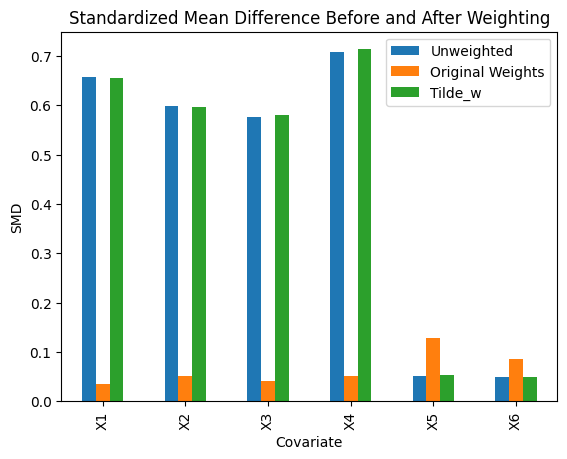

In [282]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Assuming df contains your synthetic data with covariates and treatment/outcome columns
X = df2[[f'X{i+1}' for i in range(p)]]  # Your covariates, divided into types
A = df2['A']
pi = nuis_params['hat_propen']  # Assumed available

# Calculate original weights (with correct handling for control group)
original_weights = np.where(A == 1, (A - pi) / (pi * (1 - pi)), -((A - pi) / (pi * (1 - pi))))

# Assuming tilde_w is available
tilde_w = nuis_params['hat_tilde_w']
# tilde_w = np.where(A == 1, tilde_w, -tilde_w)

# Function to calculate standardized mean difference (SMD)
def compute_smd(treated, control, weights_treated=None, weights_control=None):
    treated_mean = np.average(treated, weights=weights_treated) if weights_treated is not None else np.mean(treated)
    control_mean = np.average(control, weights=weights_control) if weights_control is not None else np.mean(control)

    pooled_var = (np.var(treated, ddof=1) + np.var(control, ddof=1)) / 2
    return abs(treated_mean - control_mean) / np.sqrt(pooled_var)
    # return abs(treated_mean - control_mean)
    
# Split treatment and control groups
treated = df2[df2['A'] == 1]
control = df2[df2['A'] == 0]

# Calculate SMD for each covariate
smd_results = {}
for covariate in X.columns:
    smd_results[covariate] = {
        'unweighted': compute_smd(treated[covariate], control[covariate]),
        'original_weights': compute_smd(treated[covariate], control[covariate], 
                                        original_weights[treated.index], original_weights[control.index]),
        'tilde_w': compute_smd(treated[covariate], control[covariate], tilde_w[treated.index], tilde_w[control.index])
    }

# Convert to a DataFrame for plotting
smd_df = pd.DataFrame(smd_results).T

# Plot the SMD for comparison
import matplotlib.pyplot as plt

smd_df.plot(kind='bar')
plt.title('Standardized Mean Difference Before and After Weighting')
plt.xlabel('Covariate')
plt.ylabel('SMD')
plt.legend(['Unweighted', 'Original Weights', 'Tilde_w'])
plt.show()


In [204]:
original_weights[treated.index]

array([1.03549471, 1.41422837, 1.31652833, ..., 2.0492008 , 1.15715244,
       3.13351325])

# Comparator testing

In [2]:
import sys
import os

# Adjust the path for Jupyter notebooks
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)

from comparator.TI_estimator.simulation import *
from comparator.TI_estimator.Qmod import *


In [23]:
raw_df = pd.read_csv('../data/music/music.csv')
simulated_df, offset =run_simulation(raw_df, propensities=[0.9, 0.1], 
                            beta_t=1.0,  # 1.0, 0.0
                            beta_c=50.0, # 50.0, 100.0
                            gamma=1.0,    # 1.0, 4.0
                            cts=True)
ate = ATE_adjusted(simulated_df['C'], simulated_df['T'], simulated_df['Y'])
print('adjusted ATE: ', ATE_adjusted(simulated_df['C'], simulated_df['T'], simulated_df['Y']))
print('unadjusted ATE: ', ATE_unadjusted(simulated_df['T'], simulated_df['Y']))

Offset: 0.4486008631491021
[0.1, 0.9]
[0.9000740192450037, 0.0999259807549963]
adjusted ATE:  0.9930044775793552
unadjusted ATE:  32.80181282782734


In [77]:
mod = QNet(batch_size = 64, # batch size for training
           a_weight = 0.1,  # loss weight for A ~ text
           y_weight = 0.1,  # loss weight for Y ~ A + text
           mlm_weight=1.0,  # loss weight for DistlBert
           modeldir='model/train') # directory for saving the best model

Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [128]:
simulated_df.drop(columns=['index'],inplace=True)
loaded_df.drop(columns=['index'],inplace=True)

In [133]:

new_df = simulated_df.sample(frac=0.2,random_state=2025)
new_df.loc[new_df.index.to_list()].index

Index([ 7133,  9932, 10790,  2972,  3866,  3089, 13115, 11150,  2488,  2056,
       ...
        2738,  8514, 13785,  6587,  2645,  4047,  3770, 14204,  9537, 15172],
      dtype='int64', length=3058)

In [142]:
new_df = simulated_df.sample(frac=0.2, random_state=2025)
missing_indices = new_df.index.difference(loaded_df.index)
print("Missing indices in loaded:", missing_indices)


Missing indices in loaded: Index([], dtype='int64')


In [145]:
# Identify valid indices
valid_indices = new_df.index.intersection(loaded_df.index)

# Slice loaded DataFrame using valid indices
sliced_loaded = loaded_df.loc[valid_indices]

      Unnamed: 0                                               text  C  T  \
1717       10039  Jackie is the best ever !!!!  I'm 75 and i've ...  1  1   
6444       34874  This CD, while an interesting look back at the...  1  0   
7067       38144  I'm a huge fan of hip-hop and I have to say th...  1  1   
613         3345  Es tan grato deleitarse escuchando estos marav...  1  1   
1277        7245  Paul Wilbur is one of my favorite worship lead...  1  1   
...          ...                                                ... .. ..   
3193       18255  You either hear this song as a satirical comme...  1  1   
2508       14134  I got my album like two weeks early and it's s...  1  1   
2928       16667  This CD was purchased to be given as a gift. T...  1  1   
8431       44810       Excellent vinyl and service - as advertised.  0  1   
8391       44620  One of the funniest albums I've ever heard. Wi...  0  1   

              Y                                                  x  
1717  

In [146]:
loaded_df.loc[new_df.index]

,Unnamed: 0,text,C,T,Y,x
1717,10039,Jackie is the best ever !!!! I'm 75 and i've ...,1,1,-0.294325,"[-0.126914531, 0.7310182452, -0.47693434360000..."
6444,34874,"This CD, while an interesting look back at the...",1,0,-0.215726,"[-0.40020558240000004, 0.8121458888, -0.436617..."
7067,38144,I'm a huge fan of hip-hop and I have to say th...,1,1,-1.723711,"[-0.0885659233, 0.6890263557, -0.3884472549000..."
613,3345,Es tan grato deleitarse escuchando estos marav...,1,1,2.406003,"[-0.460223496, 0.8940386176, -0.65850585700000..."
1277,7245,Paul Wilbur is one of my favorite worship lead...,1,1,-0.884039,"[-0.33985823390000003, 0.7013173699, -0.437508..."
...,...,...,...,...,...,...
3193,18255,You either hear this song as a satirical comme...,1,1,-2.649414,"[-0.5428543687, 0.8369091749, -0.614097774, 0...."
2508,14134,I got my album like two weeks early and it's s...,1,1,0.429390,"[-0.2479200214, 0.9403689504, -0.6061169505, 0..."
2928,16667,This CD was purchased to be given as a gift. T...,1,1,-0.510659,"[-0.0005006092, 0.7830286622, -0.5313051343, 1..."
8431,44810,Excellent vinyl and service - as advertised.,0,1,10.554784,"[-0.1652399749, 0.1293942928, -0.0355499946, 1..."


In [117]:
loaded_df = pd.read_json("../data/music/post_music.json", orient="records", lines=True)


In [40]:
df = simulated_df.sample(frac=0.2,random_state=2025).reset_index()
mod.train(df['text'],  # texts in training data
          df['T'],     # treatments in training data
          df['C'],     # confounds in training data, binary
          df['Y'],     # outcomes in training data
          epochs=20,   # the maximum number of training epochs
          learning_rate = 2e-5)  # learning rate for the training

Validating: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

A Validation loss: 0.6981413430637784
Y Validation loss: 411.57992214626734
Validation loss: 41.227806348933115
A accuracy: 0.5208333333333334


RuntimeError: Parent directory model does not exist.

In [41]:
Q0, Q1, A, Y, _ = mod.get_Q(df['text'], df['T'], df['C'], df['Y'])

Statistics computing: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s]


In [42]:
g = get_propensities(A, Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=0) # random seed for GPR 

(array([ 12.,   8.,  26.,  36.,  31.,  75., 210., 486., 473.,  80.]),
 array([0.2308101 , 0.25936154, 0.28791297, 0.31646441, 0.34501584,
        0.37356727, 0.40211871, 0.43067014, 0.45922158, 0.48777301,
        0.51632445]),
 <BarContainer object of 10 artists>)

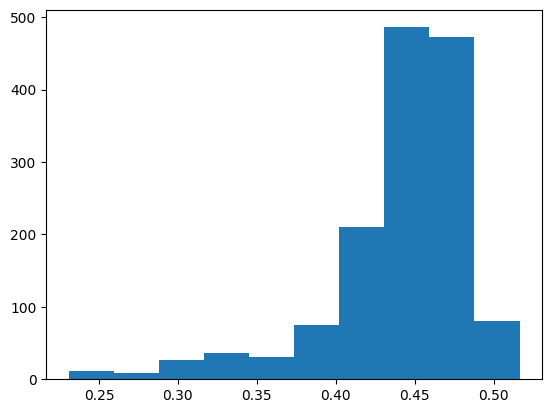

In [43]:
plt.hist(g)

In [44]:
get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)  # error bound for confidence interval

,0
point estimate,32.659959
standard error,1.006470
confidence interval lower bound,30.687315
confidence interval upper bound,34.632603


In [4]:
raw_df

,Unnamed: 0,text,C,T
0,0,This is a great cd full of worship favorites!!...,1,1
1,1,"So creative! Love his music - the words, the ...",1,1
2,2,"Keith Green, gone far to early in his carreer,...",1,1
3,3,Keith Green had his special comedy style of Ch...,1,1
4,6,Keith Green is a bit of legend in some Christi...,1,1
...,...,...,...,...
46020,55975,This music is truly mesmerizing and relaxing. ...,1,1
46021,55976,I can easily recommend this 13-disc box set of...,1,1
46022,55977,Anton Batagov is a renowned composer and piani...,1,1
46023,55978,Batagov is a masterful player of Glass piano w...,1,0


In [5]:
post_df = pre_process_text(raw_df)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.
Some weights of DistilBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.word_embeddings.weight', 'transformer.layer.0.attention.k_lin.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.attention.out_lin.weight', 'transformer.layer.0.attention.q_lin.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer

In [ ]:
post_df = post_df.drop_duplicates('text')


In [16]:
# # Save as a JSON file
# post_df.to_json("../data/music/post_music.json", orient="records", lines=True)

# Load the DataFrame back
loaded_df = pd.read_json("../data/music/post_music.json", orient="records", lines=True)

In [17]:
loaded_df = loaded_df.drop_duplicates(subset='text', keep='first')
embeddings_df = pd.DataFrame(loaded_df['x'].tolist(), columns=[f'X{i+1}' for i in range(len(loaded_df['x'][0]))])
embeddings = pd.concat([embeddings_df, loaded_df[['text']]], axis=1)


In [ ]:
embeddings = pd.concat([embeddings_df, loaded_df[['text']].reset_index(drop=True)], axis=1)
embeddings.to_json("../data/music/post_music.json", orient="records", lines=True)

In [22]:
embeddings.to_json("../data/music/post_music.json", orient="records", lines=True)

In [21]:
loaded_df

,Unnamed: 0,text,C,T,x
0,0,This is a great cd full of worship favorites!!...,1,1,"[1.4565114975, -1.2673704624, 0.8085975647, -0..."
1,1,"So creative! Love his music - the words, the ...",1,1,"[1.2581506968, -1.2064526081, 0.9312442541, -0..."
2,2,"Keith Green, gone far to early in his carreer,...",1,1,"[1.2902626991, -1.498237133, 0.8520025611, -0...."
3,3,Keith Green had his special comedy style of Ch...,1,1,"[1.4188388586, -1.3632444143, 0.5755764246, -0..."
4,6,Keith Green is a bit of legend in some Christi...,1,1,"[1.1861530542, -1.3685657978, 0.7608774304, -0..."
...,...,...,...,...,...
46020,55975,This music is truly mesmerizing and relaxing. ...,1,1,"[1.3265166283, -1.3097262383, 0.67903631930000..."
46021,55976,I can easily recommend this 13-disc box set of...,1,1,"[1.3054908514, -1.2366780043, 0.8887718916, -0..."
46022,55977,Anton Batagov is a renowned composer and piani...,1,1,"[1.3142383099, -1.3784775734, 0.7648938894, -0..."
46023,55978,Batagov is a masterful player of Glass piano w...,1,0,"[1.4110455513, -1.0329366922, 0.8285512924, -0..."


In [20]:
embeddings

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X760,X761,X762,X763,X764,X765,X766,X767,X768,text
0,1.456511,-1.267370,0.808598,-0.494551,-0.019715,0.633440,0.561888,0.041459,0.598833,0.359704,...,-0.756543,0.810317,0.186384,-0.109666,1.586607,-1.236611,-0.672431,-0.267054,1.320939,This is a great cd full of worship favorites!!...
1,1.258151,-1.206453,0.931244,-0.487264,0.257666,1.111677,0.588091,-0.114206,0.829631,0.041964,...,-0.702043,0.717782,0.677581,-0.220486,1.364310,-1.142139,-0.669426,-0.032027,0.980976,"So creative! Love his music - the words, the ..."
2,1.290263,-1.498237,0.852003,-0.528086,0.195150,0.898512,0.833852,-0.090651,0.888726,0.246883,...,-0.413295,0.556460,0.774546,-0.074691,1.455085,-1.328250,-0.528745,-0.029705,0.973880,"Keith Green, gone far to early in his carreer,..."
3,1.418839,-1.363244,0.575576,-0.434414,-0.112779,0.803557,0.342427,-0.138166,0.955045,0.103430,...,-0.789301,0.438943,0.539034,-0.124569,1.597149,-1.429878,-0.270173,0.046763,1.199321,Keith Green had his special comedy style of Ch...
4,1.186153,-1.368566,0.760877,-0.598250,-0.241222,1.103077,0.761727,-0.073117,0.854963,0.064963,...,-0.514268,0.513393,0.751489,-0.138584,1.291728,-1.056003,-0.520674,0.047123,1.070761,Keith Green is a bit of legend in some Christi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45395,1.326517,-1.309726,0.679036,-0.679274,0.076102,0.687484,0.573027,0.117946,1.004808,-0.007460,...,-0.718995,0.720617,0.614736,-0.098939,1.474577,-1.120409,-0.564686,-0.058421,0.942263,This music is truly mesmerizing and relaxing. ...
45396,1.305491,-1.236678,0.888772,-0.724023,0.005385,1.056692,0.675509,-0.037864,0.778282,0.063105,...,-0.509337,0.552583,0.561033,-0.127903,1.466600,-1.089049,-0.445740,0.024540,1.149968,I can easily recommend this 13-disc box set of...
45397,1.314238,-1.378478,0.764894,-0.469202,-0.023988,1.132040,0.765456,-0.012394,0.790771,0.020003,...,-0.414443,0.531429,0.751565,-0.012617,1.273575,-0.928612,-0.555517,0.060997,0.944017,Anton Batagov is a renowned composer and piani...
45398,1.411046,-1.032937,0.828551,-0.500187,0.128088,0.747431,0.570441,-0.079152,1.039255,0.238257,...,-0.920528,0.894448,0.353563,-0.063832,1.538211,-1.069545,-0.780165,0.053983,1.110690,Batagov is a masterful player of Glass piano w...


In [47]:
# Step 1: Extend the embeddings in 'x' into x1, ..., xp
embeddings_df = pd.DataFrame(loaded_df['x'].tolist(), columns=[f'X{i+1}' for i in range(len(loaded_df['x'][0]))])

# Step 2: Make 'C' as x_(p+1)
embeddings_df[f'X{len(loaded_df["x"][0]) + 1}'] = loaded_df['C']

# Step 3: Drop the unnecessary columns
df = pd.concat([embeddings_df, loaded_df[['T', 'Y']].rename(columns={'T': 'A', 'Y': 'y'})], axis=1)

# Step 4: Rename the columns
df.columns = [f'X{i+1}' if i < len(embeddings_df.columns) else 'A' if col == 'A' else 'y' 
                      for i, col in enumerate(df.columns)]
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X762,X763,X764,X765,X766,X767,X768,X769,A,y
0,-0.502254,0.438438,-1.881190,1.002450,0.793946,0.132427,0.927484,-0.489256,1.577028,-1.750654,...,0.524594,-0.469811,-0.592639,0.079014,-1.394577,-0.264569,-0.004519,1,0,-18.849801
1,-0.749573,0.382066,-1.838073,1.169444,1.069874,0.514441,0.649047,-0.255627,1.918420,-1.809866,...,0.922615,-0.078190,-0.203848,-0.025875,-1.811467,0.021249,0.030270,0,1,24.632166
2,-0.912613,0.556358,-1.757478,1.350078,0.619593,0.551570,0.423260,-0.183213,1.954473,-1.955853,...,0.974086,-0.285152,-0.446510,0.291703,-1.737811,-0.225848,0.022272,1,0,-16.749608
3,-0.726903,0.499819,-1.655647,1.111899,0.823289,0.512681,0.324386,-0.259200,1.923541,-1.820478,...,0.975171,-0.246064,-0.269703,0.062728,-1.734805,-0.291190,-0.139343,0,1,22.808016
4,-0.430324,0.538085,-1.873964,1.296633,0.571377,0.551178,0.428096,-0.225333,1.508219,-1.842343,...,0.921602,-0.413010,0.075693,-0.054014,-1.751263,-0.481993,0.224841,1,0,-17.961273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,-0.497918,0.556023,-1.763108,1.309869,1.088134,0.019546,0.386079,-0.416581,1.809417,-1.720979,...,0.465460,-0.203149,-0.291834,0.154721,-1.743421,-0.247952,-0.057387,1,0,-16.549625
1433,-0.553565,0.130485,-1.738070,1.394178,0.989802,0.532788,0.675637,-0.004342,2.084741,-1.393310,...,0.989948,-0.395476,-0.188469,0.041936,-1.771026,-0.293218,0.101491,1,0,-18.674682
1434,-0.521247,0.364624,-1.394807,1.481519,0.821576,0.658293,0.535745,-0.096055,1.811877,-1.547578,...,0.734426,-0.356500,-0.046242,-0.065164,-1.703081,-0.201246,0.304078,0,1,26.528239
1435,-0.729759,0.646206,-1.911149,1.365928,0.592131,0.978443,0.436420,-0.314503,1.793164,-1.105042,...,0.335049,-0.157137,-0.622048,-0.297615,-1.809928,-0.252001,0.198436,1,0,-15.628402


In [35]:
df = df.sample(frac=0.2,random_state=2025)

In [24]:
df1, df2 = [df_s.reset_index(drop=True) for df_s in np.array_split(df.sample(frac=1, random_state=2025), 2)]

nuis_params = single_split_nuisance_parameter_estimator(
    df1, df2, p=768, ps_model_type="torch_nn", or_model_type="torch_nn", w_model_type="kernel_ridge_regression",
    hyperparam_search=True, random_seed=2025
)
ate_mr = ate_mr_estimator(nuis_params['hat_w1'], nuis_params['hat_w0'], df2)
ate_mr_tilde = ate_amr_estimator(nuis_params['hat_tilde_w'], nuis_params['hat_propen'], nuis_params['hat_mu1'], nuis_params['hat_mu0'], df2)
ate_dr = ate_aipw_estimator(nuis_params['hat_mu1'], nuis_params['hat_mu0'], nuis_params['hat_propen'], df2)
ate_ipw = ate_ipw_estimator(nuis_params['hat_propen'], df2)
print("ate_mr: ", ate_mr)
print("ate_mr_tilde: ", ate_mr_tilde)
print("ate_dr: ", ate_dr)
print("ate_ipw: ", ate_ipw)

NameError: name 'df' is not defined

In [53]:
nuis_params = kfold_cross_fit_nuisance_parameter_estimator(
    df_full=df, p=768, ps_model_type="torch_nn", or_model_type="torch_nn", w_model_type="kernel_ridge_regression",
    hyperparam_search=True, random_seed=2025, n_folds=5
)
ate_mr = ate_mr_estimator(nuis_params['hat_w1'], nuis_params['hat_w0'], df)
ate_mr_tilde = ate_amr_estimator(nuis_params['hat_tilde_w'], nuis_params['hat_propen'], nuis_params['hat_mu1'], nuis_params['hat_mu0'], df)
ate_dr = ate_aipw_estimator(nuis_params['hat_mu1'], nuis_params['hat_mu0'], nuis_params['hat_propen'], df)
ate_ipw = ate_ipw_estimator(nuis_params['hat_propen'], df)
print("ate_mr: ", ate_mr)
print("ate_mr_tilde: ", ate_mr_tilde)
print("ate_dr: ", ate_dr)
print("ate_ipw: ", ate_ipw)

Best Params: {'gamma': 0.01291549665014884, 'alpha': 0.01}
Best Params: {'gamma': 0.01291549665014884, 'alpha': 0.01}
Best Params: {'gamma': 0.001, 'alpha': 0.2}
Best Params: {'gamma': 0.01291549665014884, 'alpha': 0.01}
Best Params: {'gamma': 0.01291549665014884, 'alpha': 0.01}
Best Params: {'gamma': 0.01291549665014884, 'alpha': 0.5}
Best Params: {'gamma': 0.5994842503189409, 'alpha': 0.5}
Best Params: {'gamma': 0.003593813663804626, 'alpha': 0.01}
Best Params: {'gamma': 0.003593813663804626, 'alpha': 0.5}
Best Params: {'gamma': 0.01291549665014884, 'alpha': 0.2}
Best Params: {'gamma': 0.01291549665014884, 'alpha': 0.2}
Best Params: {'gamma': 0.003593813663804626, 'alpha': 0.5}
Best Params: {'gamma': 0.5994842503189409, 'alpha': 0.5}
Best Params: {'gamma': 0.003593813663804626, 'alpha': 0.01}
Best Params: {'gamma': 0.001, 'alpha': 0.5}
ate_mr:  27.979302380985796
ate_mr_tilde:  30.16968923159121
ate_dr:  28.442679432937933
ate_ipw:  28.464573599646886


In [63]:
np.mean(A/g * (Y-Q1)+ (1-A)/(1-g)*(Y-Q0) + (np.array(Q1)-np.array(Q0)))

3.5522330858761806

In [19]:
df1, df2 = [df_s.reset_index(drop=True) for df_s in np.array_split(df.sample(frac=1, random_state=2025), 2)]

nuis_params = single_split_nuisance_parameter_estimator(
    df1, df2, p=769, ps_model_type="torch_nn", or_model_type="torch_nn", w_model_type="kernel_ridge_regression",
    hyperparam_search=True, random_seed=2025
)
ate_mr = ate_mr_estimator(nuis_params['hat_w1'], nuis_params['hat_w0'], df2)
ate_mr_tilde = ate_amr_estimator(nuis_params['hat_tilde_w'], nuis_params['hat_propen'], nuis_params['hat_mu1'], nuis_params['hat_mu0'], df2)
ate_dr = ate_aipw_estimator(nuis_params['hat_mu1'], nuis_params['hat_mu0'], nuis_params['hat_propen'], df2)
ate_ipw = ate_ipw_estimator(nuis_params['hat_propen'], df2)
print("ate_mr: ", ate_mr)
print("ate_mr_tilde: ", ate_mr_tilde)
print("ate_dr: ", ate_dr)
print("ate_ipw: ", ate_ipw)

Best Params: {'gamma': 0.1668100537200059, 'alpha': 0.1}
Best Params: {'gamma': 0.1668100537200059, 'alpha': 0.1}
Best Params: {'gamma': 0.046415888336127795, 'alpha': 0.2}
ate_mr:  1.600804373587829
ate_mr_tilde:  1.4864305386832903
ate_dr:  -3.3398160433711754
ate_ipw:  2.568302020844476


# playing with first order derivative

In [23]:
import numpy as np

def estimate_w_derivative_krr_cv(w_model_cv, X_train, X_test, y_train):
    """
    Estimate the first-order derivative of w using the best fitted Kernel Ridge Regression from RandomizedSearchCV.
    
    Args:
    - w_model_cv: RandomizedSearchCV object (the cross-validated model).
    - X_train: Training data used to fit the model.
    - X_test: Test points at which to estimate the derivative.
    - y_train: The training target values.

    Returns:
    - gradients: The estimated first-order derivatives at each test point.
    """
    # Get the best fitted Kernel Ridge Regression model from RandomizedSearchCV
    best_model = w_model_cv.best_estimator_

    # Extract the kernel width parameter (gamma) and alpha (regularization)
    gamma = best_model.get_params()['gamma']
    alpha_reg = best_model.get_params()['alpha']  # This is the regularization parameter
    
    # Compute the RBF kernel matrix between X_train and X_test
    pairwise_sq_dists = np.sum((X_train[:, np.newaxis, :] - X_train[np.newaxis, :, :])**2, axis=-1)
    K_train_train = np.exp(-gamma * pairwise_sq_dists)
    
    # Solve for the alpha (dual weights) using the Kernel Ridge Regression formula
    alpha = np.linalg.solve(K_train_train + alpha_reg * np.eye(K_train_train.shape[0]), y_train)
    
    # Compute the kernel matrix between X_train and X_test
    pairwise_sq_dists_test = np.sum((X_train[:, np.newaxis, :] - X_test[np.newaxis, :, :])**2, axis=-1)
    K_train_test = np.exp(-gamma * pairwise_sq_dists_test)

    # Compute the derivative of the RBF kernel with respect to X_test
    grad_K = -2 * gamma * (X_test[np.newaxis, :, :] - X_train[:, np.newaxis, :]) * K_train_test[:, :, np.newaxis]
    
    # Compute the gradient of the KRR prediction with respect to X_test
    gradients = np.einsum('ijk,i->jk', grad_K, alpha)
    
    return gradients


In [24]:
nuis_params.keys()

dict_keys(['hat_propen', 'hat_mu0', 'hat_mu1', 'hat_w0', 'hat_w1', 'hat_tilde_w', 'model_tilde_w', 'tilde_y_train', 'tilde_y_test', 'tilde_rho_train'])

In [25]:
derivative = estimate_w_derivative_krr_cv(nuis_params['model_tilde_w'], nuis_params['tilde_y_train'].values.reshape(-1,1), nuis_params['tilde_y_test'].values.reshape(-1,1),nuis_params['tilde_rho_train'].values)
derivative

array([[ 7.29626080e-02],
       [ 7.14470585e-02],
       [ 3.96472723e-02],
       [ 4.43967856e-02],
       [ 7.14098272e-02],
       [ 4.43834642e-02],
       [ 3.12389926e-02],
       [ 3.41472444e-02],
       [ 8.36249975e-02],
       [ 3.36611046e-02],
       [ 4.06518043e-02],
       [-1.83349611e-02],
       [ 4.62251308e-02],
       [ 2.35376505e-02],
       [-2.87732964e-02],
       [ 2.36818199e-02],
       [-4.49457326e-03],
       [-3.36908957e-03],
       [ 4.45724357e-02],
       [ 4.45240715e-02],
       [ 3.65412496e-02],
       [ 2.03688340e-02],
       [ 4.31730658e-02],
       [ 2.73388867e-02],
       [ 5.84529069e-02],
       [-6.23860590e-02],
       [ 3.03769680e-02],
       [ 7.34109383e-02],
       [ 7.33982416e-02],
       [ 3.53583714e-02],
       [ 3.58192203e-02],
       [ 8.57822627e-02],
       [ 4.91587735e-02],
       [ 2.84964432e-02],
       [ 4.00090709e-02],
       [-1.27745176e-02],
       [ 2.83467953e-02],
       [ 3.27801811e-02],
       [ 6.0

In [26]:
hat_propen, hat_mu0, hat_mu1, hat_tilde_w = nuis_params['hat_propen'], nuis_params['hat_mu0'], nuis_params['hat_mu1'], nuis_params['hat_tilde_w']

In [29]:
tilde_y = df2['y']- (1-hat_propen)*hat_mu1 - hat_propen * hat_mu0
hat_theta = np.mean(hat_tilde_w * tilde_y)
hat_h = df2['A'] / hat_propen - (1 - df2['A'])  / (1 - hat_propen)
var_tilde_w = np.mean((hat_h - hat_tilde_w)**2)
inf_smoothed = hat_tilde_w * tilde_y - hat_theta

inf_pi = (df2['A'] - hat_propen)
delta_inf_tilde_y = -hat_propen * (1-df2['A']) / (1-hat_propen) * (df2['y'] - hat_mu0)  - (1-hat_propen) * df2['A'] / hat_propen * (df2['y']-hat_mu1)##
delta_inf_tilde_y += (hat_mu1 - hat_mu0) * inf_pi

a = inf_smoothed - hat_tilde_w * delta_inf_tilde_y
b = (np.sqrt(var_tilde_w - np.var(hat_tilde_w))) * np.abs(tilde_y)
var = 1/df.shape[0] ** 2 * np.sum(a**2 + b**2)

# var = 1/df2.shape[0] ** 2 * np.sum(inf_smoothed ** 2 + (hat_tilde_w * delta_inf_tilde_y)**2 + b**2 + ( delta_inf_tilde_y * derivative.reshape(-1) * tilde_y) **2)
var = 1/df2.shape[0] ** 2 * np.sum(inf_smoothed ** 2 + (hat_tilde_w * delta_inf_tilde_y)**2 + b**2)

std = np.sqrt(var)
std

5.608208081613706

In [30]:
std_ate_aipw_estimator(nuis_params['hat_mu1'], nuis_params['hat_mu0'], nuis_params['hat_propen'], df2)

3.8928140103330864

# Previous trials

In [2]:

# generic parameters
# Parameters
n = 800
n_mc = 1000000
num_trial = 1000
gamma=10
heteroscedasticity=False
strength_instr = 0.8
p = 7
p_instr=2
data_mc = generate_synthetic_data(n_mc, p = p, p_instr=p_instr , gamma=gamma, strength_instrument= strength_instr, heteroscedasticity=heteroscedasticity, mu1_type='non_linear')
ate = np.mean(data_mc['mu1'] - data_mc['mu0'])
ate

5.001769604437992

In [3]:
def estimate_w_derivative_krr(w_model, X_train, X_test):
    """
    Estimate the first-order derivative of w using the fitted Kernel Ridge Regression (w_model).
    
    Args:
    - w_model: Fitted Kernel Ridge Regression model (with hyperparameters from cross-validation).
    - X_train: Training data used to fit the model.
    - X_test: Test points at which to estimate the derivative.
    
    Returns:
    - gradients: The estimated first-order derivatives at each test point.
    """
    # Extract dual coefficients (alphas) from the fitted KRR model
    alpha = w_model.dual_coef_.flatten()
    
    # Extract the gamma value from the kernel parameter (RBF kernel parameter)
    gamma = w_model.get_params()['gamma']
    
    # Compute RBF kernel derivatives with respect to the test points
    pairwise_sq_dists = np.sum((X_train[:, np.newaxis, :] - X_test[np.newaxis, :, :])**2, axis=-1)
    K = np.exp(-gamma * pairwise_sq_dists)

    # Compute the derivative of the RBF kernel with respect to the test point
    grad_K = -2 * gamma * (X_test[np.newaxis, :, :] - X_train[:, np.newaxis, :]) * K[:, :, np.newaxis]
    
    # Compute the gradient of the KRR prediction (w) with respect to X_test
    gradients = np.einsum('ijk,i->jk', grad_K, alpha)
    
    return gradients

(array([110053., 109427.,  98960.,  92247.,  89843.,  89284.,  92175.,
         98492., 109693., 109826.]),
 array([7.65308396e-05, 1.00048741e-01, 2.00020950e-01, 2.99993160e-01,
        3.99965370e-01, 4.99937579e-01, 5.99909789e-01, 6.99881998e-01,
        7.99854208e-01, 8.99826418e-01, 9.99798627e-01]),
 <BarContainer object of 10 artists>)

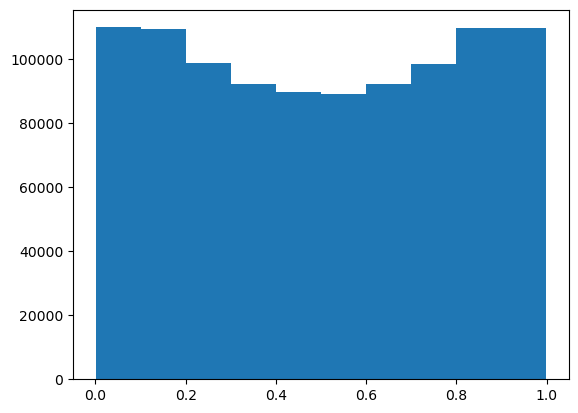

In [3]:
data_mc = generate_synthetic_data(n_mc, p = 7, p_instr=5 , gamma=20, strength_instrument= 0.8, heteroscedasticity=heteroscedasticity, mu1_type='non_linear')
plt.hist(data_mc['propen'])

In [4]:
df = generate_synthetic_data(n=800,p=p, p_instr = p_instr, strength_instrument=0.8, gamma=gamma,mu1_type='non_linear')

In [9]:
random_seed = 1024
df1, df2 = [df_s.reset_index(drop=True) for df_s in np.array_split(df.sample(frac=1, random_state=random_seed), 2)]
df1.shape[0]
df2.shape[0]
nuis_params = nuisance_parameter_estimator(df=df, df1=df1, df2=df2, p=p, ps_model = 'original', or_model='lr', w_model='kernel_ridge_regression', hyperparam_search=True, random_seed=random_seed, true_w=False, df_mc=data_mc, B=1000)
ate_mr = ate_mr_estimator(nuis_params['hat_w1'], nuis_params['hat_w0'], df2)
ate_mr_tilde = ate_amr_estimator(nuis_params['hat_tilde_w'], nuis_params['hat_propen'], nuis_params['hat_mu1'], nuis_params['hat_mu0'], df2)

ate_dr = ate_aipw_estimator(nuis_params['hat_mu1'], nuis_params['hat_mu0'], nuis_params['hat_propen'], df2)
ate_ipw = ate_ipw_estimator(nuis_params['hat_propen'], df2)

In [10]:
ate_mr

3.580559723854325

In [11]:
ate_dr

11.744093500839101

In [12]:
ate

5.0020406898752805

In [13]:
ate_mr_tilde

2.233843892635932

In [14]:
df1.shape[0]

400

In [15]:
df2.shape[0]

400

In [16]:
std_ate_aipw_estimator(nuis_params['hat_mu1'], nuis_params['hat_mu0'], nuis_params['hat_propen'], df2) 

4.037503889368178

In [17]:
std_ate_amr_estimator(nuis_params['hat_tilde_w'], nuis_params['hat_propen'], nuis_params['hat_mu1'], nuis_params['hat_mu0'], nuis_params['derivatives'],df2) 

13.92793100913266

In [13]:
hat_propen = nuis_params['hat_propen']
hat_tilde_w = nuis_params['hat_tilde_w']
hat_mu1 = nuis_params['hat_mu1']
hat_mu0 = nuis_params['hat_mu0']
tilde_w_derivatives =  nuis_params['derivatives']

tilde_y = df2['y']- (1-hat_propen)*hat_mu1 - hat_propen * hat_mu0
hat_theta = np.mean(hat_tilde_w * tilde_y)
hat_h = df2['A'] / hat_propen - (1 - df2['A'])  / (1 - hat_propen)
var_tilde_w = np.mean((hat_h - hat_tilde_w)**2)
# delta_inf_tilde_w = (tilde_y - np.mean(tilde_y))* np.sqrt(var_tilde_w)
delta_inf_tilde_w = (hat_tilde_w - hat_h)
# delta_inf_tilde_w = tilde_y* np.sqrt(var_tilde_w)
inf_pi = (df2['A'] - hat_propen) / (hat_propen * (1-hat_propen))
delta_inf_tilde_y = -hat_propen * (1-df2['A']) / (1-hat_propen) * (df2['y'] - hat_mu0)  - (1-hat_propen) * df2['A'] / hat_propen * (df2['y']-hat_mu1)
delta_inf_tilde_y += (hat_mu1 - hat_mu0) * inf_pi

b = (np.sqrt(var_tilde_w) - np.sqrt(np.var(hat_tilde_w))) * tilde_y



In [16]:
(np.sqrt(var_tilde_w) - np.sqrt(np.var(hat_tilde_w)))

1.9972321192331564

In [18]:
delta_inf_tilde_y * tilde_y * tilde_w_derivatives

0           4.428442
1          -3.184778
2           0.209513
3           2.918074
4       14547.114386
            ...     
4995       -0.402366
4996      -28.341977
4997       18.071144
4998        0.107369
4999        4.100751
Length: 5000, dtype: float64

In [22]:
delta_inf_tilde_y

0        -2.132255
1        -5.544049
2        -7.317888
3        -9.983958
4      -186.275193
           ...    
4995     13.166767
4996    -25.187382
4997     22.236129
4998      1.344109
4999     15.890092
Length: 5000, dtype: float64

In [20]:
tilde_w_derivatives[3]

0.018444048699711682

In [21]:
tilde_y

0        16.439938
1        -9.240687
2        -2.761890
3       -15.846642
4       256.926110
           ...    
4995     -0.299431
4996     26.296939
4997    -26.003006
4998    -19.829055
4999     -4.995190
Name: y, Length: 5000, dtype: float64

In [53]:
delta_inf_tilde_y

0        5.894897
1       -0.263898
2       57.065542
3       -1.728090
4       12.013921
          ...    
4995    -5.336390
4996    11.268104
4997     3.437038
4998    10.703504
4999    -2.797932
Length: 5000, dtype: float64

(array([1.000e+00, 0.000e+00, 8.000e+00, 5.160e+02, 4.233e+03, 2.330e+02,
        4.000e+00, 1.000e+00, 0.000e+00, 4.000e+00]),
 array([-8.51930796, -6.54638311, -4.57345825, -2.6005334 , -0.62760855,
         1.3453163 ,  3.31824115,  5.291166  ,  7.26409086,  9.23701571,
        11.20994056]),
 <BarContainer object of 10 artists>)

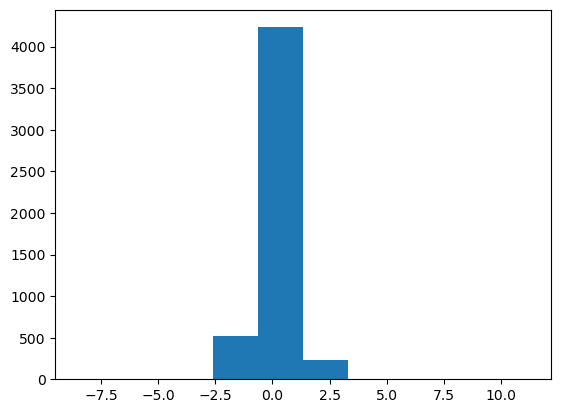

In [31]:
plt.hist(hat_tilde_w)